In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import cv2

In [2]:
class Transmission:
    def __init__(self, max_speed, num_gears):
        self.max_speed = max_speed
        self.num_gears = num_gears
        self.gear_ratios = [i / num_gears for i in range(1, num_gears + 1)]  # Просто линейная интерполяция

    def get_speed(self, throttle, current_speed):
        # Рассчитываем текущую передачу на основе throttle и количества передач
        current_gear = int(throttle * self.num_gears)
        current_gear = min(current_gear, self.num_gears - 1)  # Убеждаемся, что текущая передача не превышает максимального значения

        # Рассчитываем скорость с учетом передачи и максимальной скорости
        target_speed = self.max_speed * self.gear_ratios[current_gear]

        # Плавно изменяем скорость от текущей к целевой скорости
        if current_speed < target_speed:
            current_speed += 0.1  # Например, наращиваем скорость на фиксированную величину
            current_speed = min(current_speed, target_speed)  # Убеждаемся, что не превышаем целевую скорость
        elif current_speed > target_speed:
            current_speed -= 0.1  # Например, уменьшаем скорость на фиксированную величину
            current_speed = max(current_speed, target_speed)  # Убеждаемся, что не опускаемся ниже целевой скорости

        return current_speed


In [3]:
trnsm = Transmission(10,4)

In [8]:
throttle = 0
logs = []

for i in range(20):
    speed = i
    throttle += 0.01
    speed = trnsm.get_speed(throttle, speed)
    logs.append(speed)

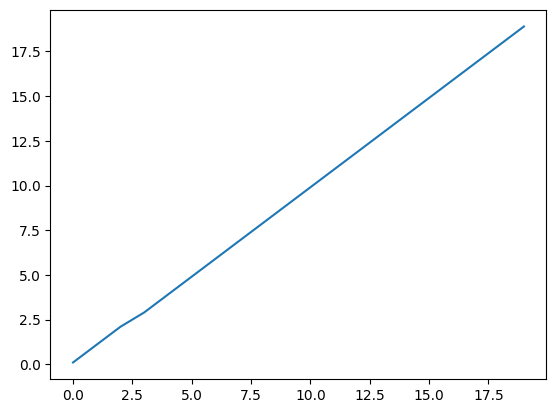

In [9]:
plt.plot(logs)

In [10]:
throttle

0.20000000000000004

In [1]:
a = [[1,2,3,4], [5,6,7,8]]

In [2]:
for bbox in a:
    print(bbox)

[1, 2, 3, 4]
[5, 6, 7, 8]


In [ ]:
class PIDController:
    def __init__(self, P=1.0, I=0.0, D=0.0):
        self.Kp = P
        self.Ki = I
        self.Kd = D
        self.prev_error = 0.0
        self.integral = 0.0

    def update(self, error, dt):
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt
        output = (self.Kp * error) + (self.Ki * self.integral) + (self.Kd * derivative)
        self.prev_error = error
        return output

In [16]:
def ipm_ll(image):
    # for single lane

    x1, y1 = 210, 480
    x2, y2 = 300, 315
    x3, y3 = 400, 315
    x4, y4 = 590, 480

    u1, v1 = x1, y1
    u2, v2 = 210, 0
    u3, v3 = 500, 0
    u4, v4 = x4, y4


    # for all road
    '''x1, y1 = 0, 480
    x2, y2 = 150, 360
    x3, y3 = 480, 360
    x4, y4 = 640, 480

    u1, v1 = x1, y1
    u2, v2 = 0, 0
    u3, v3 = 640, 0
    u4, v4 = x4, y4'''
    
    image = np.asanyarray(image, dtype=np.uint8)
    image = cv2.resize(image, dsize=(640, 480))
    
    # camera points
    points_camera = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], dtype=np.float32)

    # birds-eye view points
    points_birdseye = np.array([[u1, v1], [u2, v2], [u3, v3], [u4, v4]], dtype=np.float32)

    homography_matrix, _ = cv2.findHomography(points_camera, points_birdseye)

    transformed_image = cv2.warpPerspective(image, homography_matrix, (640, 480)) # cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))

    return transformed_image


In [2]:
img = cv2.imread('cv_frame.jpg')

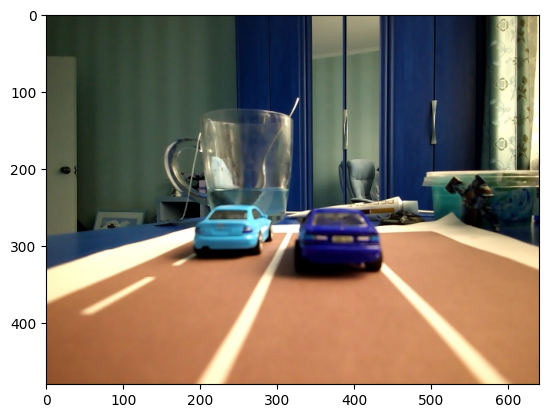

In [7]:
imshow(img)

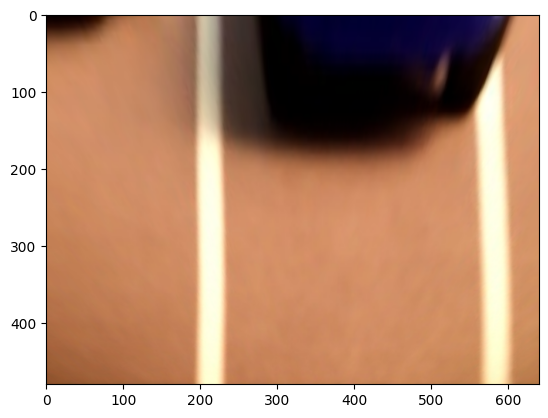

In [17]:
tr_img = ipm_ll(img)
imshow(tr_img)

In [29]:
xyxy = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
points = xyxy.reshape(-1, 2)
points = points.reshape(-1,1,2) #.astype(np.uint8) 
points

array([[[1, 2]],

       [[3, 4]],

       [[5, 6]],

       [[7, 8]]])

In [30]:
new_points = points.reshape(-1, 4)
new_points

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [23]:
new_points = np.array(new_points, dtype=np.uint8)
new_points

array([[1, 2, 3, 4],
       [5, 6, 7, 8]], dtype=uint8)